# PyABC - Morpheus - minimal example

In this notebook, we demonstrate a minimal use case of parameter inference of a Morpheus model using pyABC. It roughly follows the example in the notebook called `multiscale_agent_based.ipynb`.

- The Morpheus model simulates a simple logistic function and return time series data.
- We use a thin python wrapper around Morpheus.
- We generate synthetic ground truth data with known parameters.
- We use pyABC to infer those parameters, based on a simple mean square error distance metric.

Note:
- The wrapper turns out to be **not threadsafe**. Therefore, until we fix this, you need to set `max_workers=1`.

## PyMorpheus wrapper

- we define some paths 

In [1]:
SIMULATOR = '/Users/wdeback/Software/morpheus2rc1/build/morpheus/core/morpheus'
MODEL = '/Users/wdeback/Work/FitMultiCell/models/Logistic.xml'
RESULTFILE = 'logger.csv'
MORPHEUS_WRAPPER = '/Users/wdeback/Work/FitMultiCell/pymorpheus' 

- we import a simple python wrapper for Morpheus

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
if MORPHEUS_WRAPPER not in sys.path:
    sys.path.append(MORPHEUS_WRAPPER)

from pymorpheus import Morpheus

- define a Morpheus simulation of the given model (`model_path`) with the given parameters(`params_dict`)
- this returns a `pandas DataFrame` with the results read from the specified `RESULTFILE`

In [3]:
sim = Morpheus(morpheus_exec_path=SIMULATOR, 
         model_path=MODEL, 
         results_fn=RESULTFILE,
         verbose=True,
         output='dataframe')

sim

simulator:	/Users/wdeback/Software/morpheus2rc1/build/morpheus/core/morpheus
model:	/Users/wdeback/Work/FitMultiCell/models/Logistic.xml
results:	logger.csv
output:	dataframe
verbosity:	True

- run the model and plot results

In [4]:
params = {'r':0.025, 'K':0.8}
df = sim.simulate(params_dict=params)
df.plot('time', 'x', marker='o')

/Users/wdeback/Software/morpheus2rc1/build/morpheus/core/morpheus -file /Users/wdeback/Work/FitMultiCell/models/Logistic.xml -r=0.025  -K=0.8 

    time         x
0      0  0.010000
1     25  0.018482
2     50  0.033849
3     75  0.060998
4    100  0.106882
5    125  0.178927
6    150  0.279921
7    175  0.401106
8    200  0.522087
9    225  0.622604
10   250  0.694137
11   275  0.739622
12   300  0.766508
13   325  0.781717
14   350  0.790109
15   375  0.794675
16   400  0.797141
17   425  0.798467
18   450  0.799179
19   475  0.799560
20   500  0.799765



- pyABC expects the simulation model to return a `dict` instead of a `dataframe`

In [5]:
sim.set_verbosity(False)
sim.set_output('dict')
sim

simulator:	/Users/wdeback/Software/morpheus2rc1/build/morpheus/core/morpheus
model:	/Users/wdeback/Work/FitMultiCell/models/Logistic.xml
results:	logger.csv
output:	dict
verbosity:	False

- create reference (observed) data

In [6]:
params = {'r':0.025, 'K':0.8}
reference = sim.simulate(params_dict=params)
reference

{'time': [0,
  25,
  50,
  75,
  100,
  125,
  150,
  175,
  200,
  225,
  250,
  275,
  300,
  325,
  350,
  375,
  400,
  425,
  450,
  475,
  500],
 'x': [0.01,
  0.01848173726,
  0.03384924752,
  0.060997548799999995,
  0.10688235310000001,
  0.1789267743,
  0.2799212205,
  0.4011056536,
  0.5220872012,
  0.6226038361999999,
  0.6941369615,
  0.739622456,
  0.766507513,
  0.7817170682,
  0.7901088178,
  0.7946750467,
  0.7971409207,
  0.7984671031,
  0.7991787701999999,
  0.7995602187,
  0.7997645425]}

## PyABC

In [7]:
from pyabc import Distribution, RV

# define limits
limits = {'r':(0.0, 0.1),
          'K':(0.0, 1.0)}

# define priors as uniform distribution within the limits
priors = Distribution(**{key: RV("uniform", a, b - a) for key, (a,b) in limits.items()})

- we need to define a distance function



In [8]:
### simple approach: define distance function
def mse_distance(x:dict, y:dict) -> float:
    import numpy as np
    a = np.array(x['x'])
    b = np.array(y['x'])
    return sum((a-b)**2)


### for more control, you can subclass pyabc.distance.Distance 
from pyabc.distance import Distance
class LogisticDistance(Distance):
    __name__ 
    def __init__(self, name: str):
        self.name = name
        pass
    
    def __call__(self, x: dict, y: dict, t:int, params:dict) -> float:
        import numpy as np
        a = np.array(x[self.name])
        b = np.array(y[self.name])

        if len(a) != len(b):
            print(f'error, unequal lengths {len(a), len(b)}')
            import sys
            return sys.float_info.max

        err = np.sum((a-b)**2)
        
        if err == 0.0:
            print(f'PROBABLY AN ERROR, can be caused by multithreading. Please set max_workers=1.')
            print(f'err    = {err}')
            print(f'params = {params}')
            print(f'a      = {a}')
            print(f'a      = {v}')
            print()
        return err    
    def get_config(self):
        return {}

In [9]:
from pyabc import ABCSMC
from pyabc.sampler import ConcurrentFutureSampler
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=1) # TODO: make pymorpheus.Morpheus.simulate() threadsafe!
sampler = ConcurrentFutureSampler(pool)


abc = ABCSMC(
        models=sim.simulate, # function that takes parameter dict  
        parameter_priors=priors,
        distance_function=mse_distance, #LogisticDistance(name='x'),
        population_size=50,
        sampler=sampler)


We initialize a new ABC inference run with the ``new`` method.

In [10]:
abc.new("sqlite:////tmp/test.db", reference)

INFO:History:Start <ABCSMC(id=57, start_time=2019-06-12 18:13:44.472694, end_time=None)>


57

- run sequential ABC for n generations 

In [11]:
import time
tic = time.time()
history = abc.run(max_nr_populations=10, minimum_epsilon=0.1)
toc = time.time()
print(f'Inference took {toc-tic:.2f} sec.')

INFO:Epsilon:initial epsilon is 2.9556856425151103
INFO:ABC:t:0 eps:2.9556856425151103
INFO:ABC:t:1 eps:1.357690955425278
INFO:ABC:t:2 eps:0.8135634476906325
INFO:ABC:t:3 eps:0.3071098635055468
INFO:ABC:t:4 eps:0.17763979699765428
INFO:ABC:t:5 eps:0.11038115968864613
INFO:ABC:t:6 eps:0.05023778551306953
INFO:History:Done <ABCSMC(id=57, start_time=2019-06-12 18:13:44.472694, end_time=2019-06-12 18:17:30.733538)>


Inference took 225.95 sec.


- visualize the results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126044b70>,
      dtype=object)

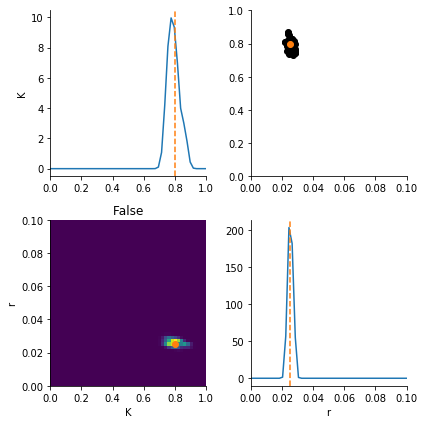

In [12]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution()
plot_kde_matrix(df, w, limits=limits, refval=params, colorbar=False, height=3.0)